In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from pathlib import Path
import glob
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))} GPU(s)")

if tf.config.list_physical_devices('GPU'):
    print("GPU acceleration is available!")
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected. Using CPU only.")

print("Environment setup complete!")


TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU Available: 1 GPU(s)
GPU acceleration is available!
Environment setup complete!


In [ ]:
BASE_PATH = '/content/drive/MyDrive/rice'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE_INITIAL = 0.001
LEARNING_RATE_FINETUNE = 0.0001

if not os.path.exists(BASE_PATH):
    print(f"Dataset path not found: {BASE_PATH}")
    print("Available directories in MyDrive:")
    drive_contents = os.listdir("/content/drive/MyDrive/")
    for item in sorted(drive_contents):
        item_path = os.path.join("/content/drive/MyDrive/", item)
        if os.path.isdir(item_path):
            print(f"    {item}/")

    print("\nPlease update BASE_PATH above to match your rice dataset folder location")
    print("   Example: BASE_PATH = '/content/drive/MyDrive/your_rice_folder_name'")

else:
    print(f"Dataset path found: {BASE_PATH}")

    print(f"\nRice Dataset Structure:")
    subfolders = []

    for item in os.listdir(BASE_PATH):
        item_path = os.path.join(BASE_PATH, item)
        if os.path.isdir(item_path):
            subfolders.append(item)

    subfolders.sort()

    if len(subfolders) == 0:
        print("No class folders found in the dataset directory!")
        print("Expected structure: rice/class1/, rice/class2/, etc.")
    else:
        CLASS_NAMES = subfolders
        NUM_CLASSES = len(CLASS_NAMES)
        LABEL_MAP = {i: class_name for i, class_name in enumerate(CLASS_NAMES)}

        total_images = 0
        for i, folder in enumerate(subfolders):
            folder_path = os.path.join(BASE_PATH, folder)
            image_files = [f for f in os.listdir(folder_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            image_count = len(image_files)
            total_images += image_count
            print(f"   {i}: {folder} → {image_count:,} images")

        print(f"\nClass Mapping Dictionary:")
        for idx, name in LABEL_MAP.items():
            print(f"   Class {idx}: '{name}'")

        print(f"\nDataset Summary:")
        print(f"   Total Classes: {NUM_CLASSES}")
        print(f"   Total Images: {total_images:,}")

        if total_images < 100:
            print("Warning: Very small dataset. Consider data augmentation.")
        elif total_images < 1000:
            print("Small dataset detected. Transfer learning is recommended.")
        else:
            print("Good dataset size for deep learning.")


Dataset path found: /content/drive/MyDrive/rice

Rice Dataset Structure:
   0: black → 353 images
   1: brown → 152 images
   2: chalky → 212 images
   3: yellow → 68 images

Class Mapping Dictionary:
   Class 0: 'black'
   Class 1: 'brown'
   Class 2: 'chalky'
   Class 3: 'yellow'

Dataset Summary:
   Total Classes: 4
   Total Images: 785
Small dataset detected. Transfer learning is recommended.


In [ ]:
def create_datasets(base_path, validation_split=0.2, test_split=0.2, seed=42):


    print("Creating datasets from directory structure...")

    train_val_ds = tf.keras.utils.image_dataset_from_directory(
        base_path,
        validation_split=test_split,
        subset="training",
        seed=seed,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=True
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        base_path,
        validation_split=test_split,
        subset="validation",
        seed=seed,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=True
    )

    class_names = train_val_ds.class_names


    val_batches = tf.data.experimental.cardinality(train_val_ds).numpy()

    val_size = int(validation_split * val_batches)

    if val_size == 0:
        val_size = 1

    val_ds = train_val_ds.take(val_size)
    train_ds = train_val_ds.skip(val_size)

    return train_ds, val_ds, test_ds, class_names

try:
    train_ds, val_ds, test_ds, detected_class_names = create_datasets(BASE_PATH)

    train_batches = tf.data.experimental.cardinality(train_ds).numpy()
    val_batches = tf.data.experimental.cardinality(val_ds).numpy()
    test_batches = tf.data.experimental.cardinality(test_ds).numpy()

    print(f"\nDataset Split Summary:")
    print(f"   Training: {train_batches} batches (≈{train_batches * BATCH_SIZE:,} images)")
    print(f"   Validation: {val_batches} batches (≈{val_batches * BATCH_SIZE:,} images)")
    print(f"   Test: {test_batches} batches (≈{test_batches * BATCH_SIZE:,} images)")

    print(f"\nDetected Classes: {detected_class_names}")

    if 'CLASS_NAMES' in globals() and detected_class_names != CLASS_NAMES:
        print("Updating class mapping to match detected classes...")

    CLASS_NAMES = detected_class_names
    NUM_CLASSES = len(CLASS_NAMES)
    LABEL_MAP = {i: name for i, name in enumerate(CLASS_NAMES)}

    print(f"Class mapping updated:")
    for idx, name in LABEL_MAP.items():
        print(f"   Class {idx}: {name}")

    print(f"\nCalculating actual sample distribution...")

    def count_samples(dataset):
        total = 0
        for batch in dataset:
            total += len(batch[0])
        return total

    print("   Counting training samples...")
    train_samples = count_samples(train_ds)
    print("   Counting validation samples...")
    val_samples = count_samples(val_ds)
    print("   Counting test samples...")
    test_samples = count_samples(test_ds)

    total_dataset_samples = train_samples + val_samples + test_samples

    print(f"\nFinal Dataset Distribution:")
    print(f"   Training samples: {train_samples:,} ({train_samples/total_dataset_samples*100:.1f}%)")
    print(f"   Validation samples: {val_samples:,} ({val_samples/total_dataset_samples*100:.1f}%)")
    print(f"   Test samples: {test_samples:,} ({test_samples/total_dataset_samples*100:.1f}%)")
    print(f"   Total samples: {total_dataset_samples:,}")

    if train_samples < 100:
        print("Small training set detected. Consider data augmentation.")
    elif val_samples < 20:
        print("Small validation set detected. Results may be less reliable.")
    else:
        print("Dataset distribution looks good!")

    total_samples = train_samples

    print("Dataset creation successful!")

except Exception as e:
    print(f"Error creating datasets: {str(e)}")
    print("Trying alternative approach...")

    try:
        print("Using alternative dataset creation method...")

        full_ds = tf.keras.utils.image_dataset_from_directory(
            BASE_PATH,
            seed=42,
            image_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            label_mode='categorical',
            shuffle=False
        )

        CLASS_NAMES = full_ds.class_names
        NUM_CLASSES = len(CLASS_NAMES)
        LABEL_MAP = {i: name for i, name in enumerate(CLASS_NAMES)}

        print(f"Detected {NUM_CLASSES} classes: {CLASS_NAMES}")

        train_val_ds = tf.keras.utils.image_dataset_from_directory(
            BASE_PATH,
            validation_split=0.2,
            subset="training",
            seed=42,
            image_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            label_mode='categorical',
            shuffle=True
        )

        test_ds = tf.keras.utils.image_dataset_from_directory(
            BASE_PATH,
            validation_split=0.2,
            subset="validation",
            seed=42,
            image_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            label_mode='categorical',
            shuffle=True
        )

        train_val_size = tf.data.experimental.cardinality(train_val_ds).numpy()
        val_size = max(1, int(0.2 * train_val_size))

        val_ds = train_val_ds.take(val_size)
        train_ds = train_val_ds.skip(val_size)

        print(f"  Alternative method successful!")
        print(f"   Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
        print(f"   Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
        print(f"   Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

        total_samples = sum([len(batch[0]) for batch in train_ds])
        print(f"   Estimated training samples: {total_samples}")

    except Exception as e2:
        print(f" Alternative method also failed: {str(e2)}")
        print("Please manually verify your dataset structure:")
        print(f"   Expected structure: {BASE_PATH}/class1/, {BASE_PATH}/class2/, etc.")
        print("   Each class folder should contain image files (.jpg, .jpeg, .png)")

        try:
            contents = os.listdir(BASE_PATH)
            print(f"   Directory contents: {contents}")
            for item in contents:
                item_path = os.path.join(BASE_PATH, item)
                if os.path.isdir(item_path):
                    file_count = len([f for f in os.listdir(item_path)
                                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    print(f"     {item}/: {file_count} images")
        except:
            print("   Could not list directory contents")


Creating datasets from directory structure...
Found 785 files belonging to 4 classes.
Using 628 files for training.
Found 785 files belonging to 4 classes.
Using 157 files for validation.

Dataset Split Summary:
   Training: 32 batches (≈512 images)
   Validation: 8 batches (≈128 images)
   Test: 10 batches (≈160 images)

Detected Classes: ['black', 'brown', 'chalky', 'yellow']
Class mapping updated:
   Class 0: black
   Class 1: brown
   Class 2: chalky
   Class 3: yellow

Calculating actual sample distribution...
   Counting training samples...
   Counting validation samples...
   Counting test samples...

Final Dataset Distribution:
   Training samples: 500 (63.7%)
   Validation samples: 128 (16.3%)
   Test samples: 157 (20.0%)
   Total samples: 785
Dataset distribution looks good!
Dataset creation successful!


   Processing batch 1...


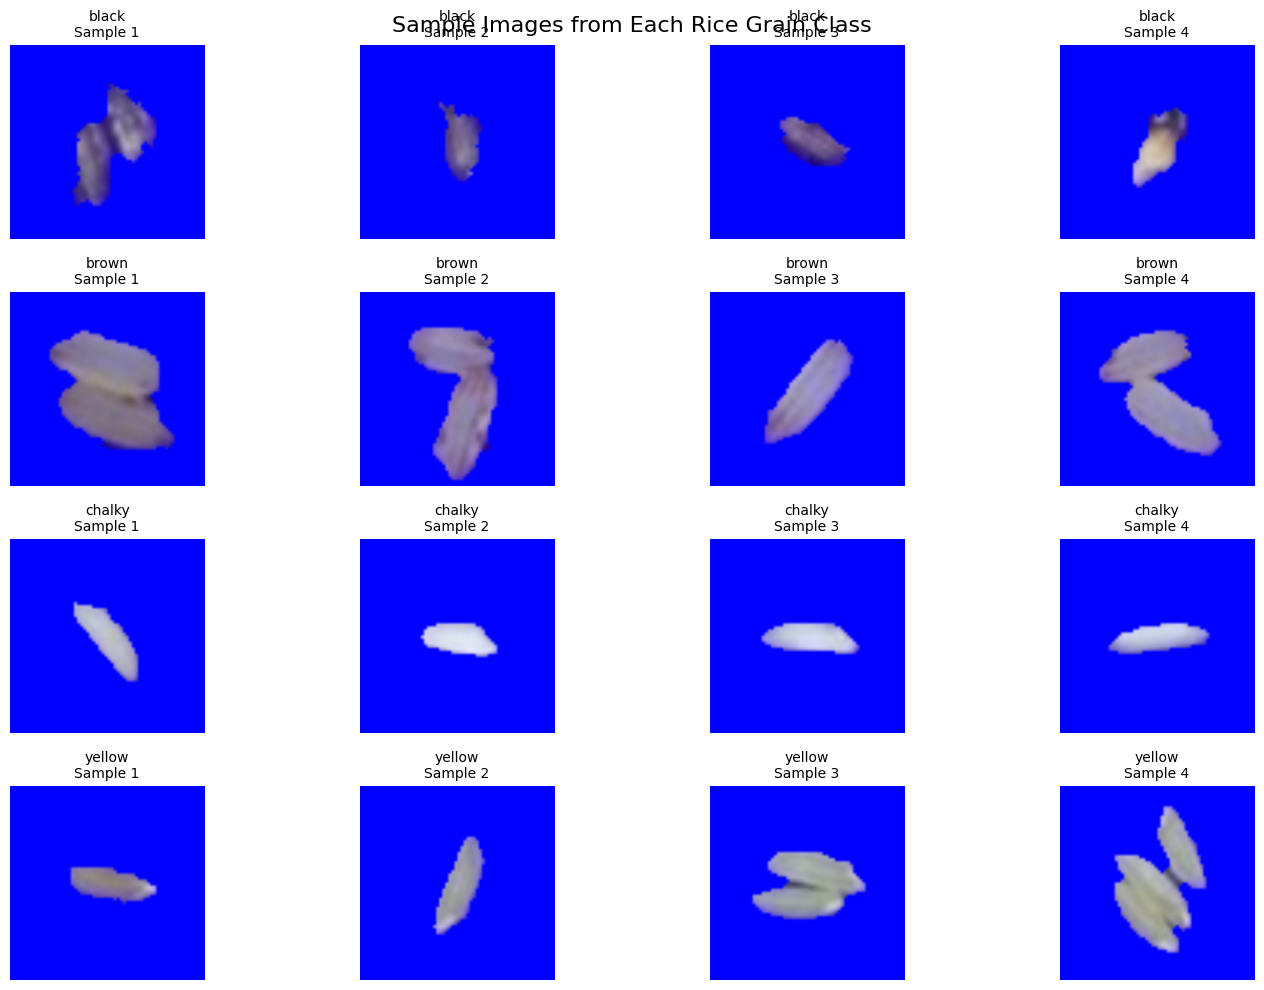

Sample visualization complete!


In [ ]:
def plot_sample_images(dataset, class_names, samples_per_class=3):
    """Display sample images from each class"""

    print("Collecting sample images for visualization...")
    plt.figure(figsize=(15, len(class_names) * 2.5))

    class_images = {i: [] for i in range(len(class_names))}

    for batch_num, (images, labels) in enumerate(dataset.take(50)):
        if batch_num % 10 == 0:
            print(f"   Processing batch {batch_num + 1}...")

        for img, label in zip(images, labels):
            true_label = np.argmax(label)
            if len(class_images[true_label]) < samples_per_class:
                display_img = img.numpy().astype('uint8')
                class_images[true_label].append(display_img)

        if all(len(samples) >= samples_per_class for samples in class_images.values()):
            break

    for class_idx, class_name in enumerate(class_names):
        available_samples = len(class_images[class_idx])
        for sample_idx in range(min(samples_per_class, available_samples)):
            subplot_idx = class_idx * samples_per_class + sample_idx + 1
            plt.subplot(len(class_names), samples_per_class, subplot_idx)

            if sample_idx < available_samples:
                img = class_images[class_idx][sample_idx]
                plt.imshow(img)
                plt.title(f'{class_name}\nSample {sample_idx + 1}', fontsize=10)
            else:
                plt.text(0.5, 0.5, 'No Image', ha='center', va='center', transform=plt.gca().transAxes)
                plt.title(f'{class_name}\nNo Sample', fontsize=10)

            plt.axis('off')

    plt.suptitle('Sample Images from Each Rice Grain Class', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

try:
    plot_sample_images(train_ds, CLASS_NAMES, samples_per_class=4)
    print("Sample visualization complete!")
except Exception as e:
    print(f"  Visualization error: {str(e)}")
    print("Continuing with model training...")


In [ ]:
def preprocess_for_efficientnet(image, label):

    image = tf.cast(image, tf.float32)
    return image, label

def augment_training_data(image, label):

    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_flip_left_right(image)

    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_flip_up_down(image)

    if tf.random.uniform([]) > 0.6:
        k = tf.random.uniform([], 0, 4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)

    if tf.random.uniform([]) > 0.7:
        image = tf.image.random_brightness(image, max_delta=0.1 * 255)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
        image = tf.image.random_hue(image, max_delta=0.05)

    image = tf.clip_by_value(image, 0.0, 255.0)

    return image, label

def optimize_dataset_performance(ds, shuffle=False, augment=False):

    ds = ds.map(preprocess_for_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        ds = ds.map(augment_training_data, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True)

    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

print("  Applying preprocessing and augmentation...")

train_ds_processed = optimize_dataset_performance(train_ds, shuffle=True, augment=True)
val_ds_processed = optimize_dataset_performance(val_ds, shuffle=False, augment=False)
test_ds_processed = optimize_dataset_performance(test_ds, shuffle=False, augment=False)

print("  Data preprocessing complete!")
print("   Training set: Augmentation + Shuffle enabled")
print("   Validation set: No augmentation, no shuffle")
print("   Test set: No augmentation, no shuffle")
print("   All datasets cached and prefetched for performance")


  Applying preprocessing and augmentation...
  Data preprocessing complete!
   Training set: Augmentation + Shuffle enabled
   Validation set: No augmentation, no shuffle
   Test set: No augmentation, no shuffle
   All datasets cached and prefetched for performance


 Analyzing class distribution...

 Training Set Class Distribution:
------------------------------------------------------------
Class Name           Count    Percentage   Weight  
------------------------------------------------------------
black                225      45.0       % 0.556  
brown                96       19.2       % 1.302  
chalky               130      26.0       % 0.962  
yellow               49       9.8        % 2.551  
------------------------------------------------------------
Total                500      100.0%       -       


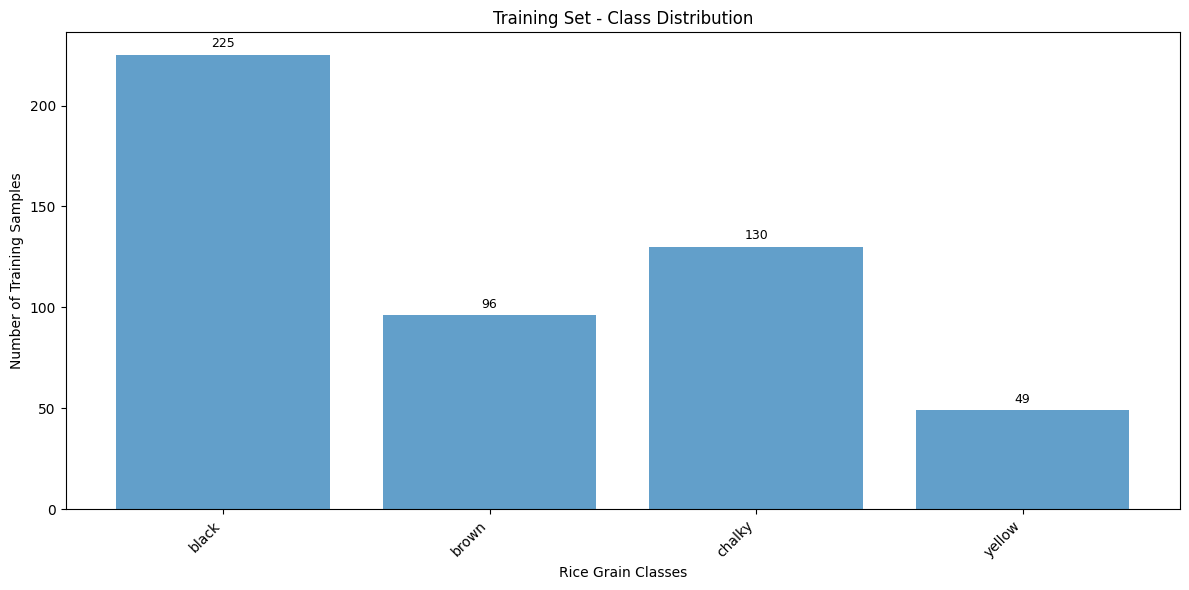


  Class Balance Analysis:
   Most frequent class: 225 samples
   Least frequent class: 49 samples
   Imbalance ratio: 4.59:1
  Significant class imbalance detected. Using weighted training.


In [ ]:
def analyze_class_distribution(dataset, class_names):

    print(" Analyzing class distribution...")

    class_counts = np.zeros(len(class_names), dtype=int)
    total_samples = 0

    for batch_images, batch_labels in dataset:
        for label in batch_labels:
            class_idx = np.argmax(label.numpy())
            class_counts[class_idx] += 1
            total_samples += 1

    class_weights = []
    for count in class_counts:
        if count > 0:
            weight = total_samples / (len(class_names) * count)
            class_weights.append(weight)
        else:
            class_weights.append(1.0)

    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    return class_counts, class_weight_dict, total_samples

class_counts, class_weight_dict, total_samples = analyze_class_distribution(train_ds_processed, CLASS_NAMES)

print(f"\n Training Set Class Distribution:")
print("-" * 60)
print(f"{'Class Name':<20} {'Count':<8} {'Percentage':<12} {'Weight':<8}")
print("-" * 60)

for i, class_name in enumerate(CLASS_NAMES):
    count = class_counts[i]
    percentage = (count / total_samples) * 100 if total_samples > 0 else 0
    weight = class_weight_dict[i]
    print(f"{class_name:<20} {count:<8} {percentage:<11.1f}% {weight:<7.3f}")

print("-" * 60)
print(f"{'Total':<20} {total_samples:<8} {'100.0%':<12} {'-':<8}")

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(CLASS_NAMES)), class_counts, alpha=0.7)
plt.xlabel('Rice Grain Classes')
plt.ylabel('Number of Training Samples')
plt.title('Training Set - Class Distribution')
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(class_counts) * 0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

max_count = np.max(class_counts)
min_count = np.min(class_counts[class_counts > 0])
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\n  Class Balance Analysis:")
print(f"   Most frequent class: {max_count:,} samples")
print(f"   Least frequent class: {min_count:,} samples")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("  Significant class imbalance detected. Using weighted training.")
else:
    print(" Classes are reasonably balanced.")


In [ ]:
def create_efficientnet_classifier():

    print("Building EfficientNet-B0 transfer learning model...")

    base_model = keras.applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMAGE_SIZE, 3)
    )

    base_model.trainable = False
    print(f" EfficientNet-B0 loaded with {len(base_model.layers)} layers")

    inputs = keras.Input(shape=(*IMAGE_SIZE, 3), name='input_layer')

    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

    x = layers.BatchNormalization(name='bn_features')(x)

    x = layers.Dropout(0.2, name='dropout_features')(x)

    x = layers.Dense(512, activation='relu', name='dense_512')(x)
    x = layers.BatchNormalization(name='bn_dense_512')(x)
    x = layers.Dropout(0.3, name='dropout_512')(x)

    x = layers.Dense(256, activation='relu', name='dense_256')(x)
    x = layers.BatchNormalization(name='bn_dense_256')(x)
    x = layers.Dropout(0.2, name='dropout_256')(x)

    if NUM_CLASSES >= 5:
        x = layers.Dense(128, activation='relu', name='dense_128')(x)
        x = layers.BatchNormalization(name='bn_dense_128')(x)
        x = layers.Dropout(0.1, name='dropout_128')(x)

    outputs = layers.Dense(
        NUM_CLASSES,
        activation='softmax',
        name='predictions',
        kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)

    model = keras.Model(inputs, outputs, name='rice_efficientnet_classifier')

    print(f" Custom classification head added with {NUM_CLASSES} output classes")

    return model, base_model

try:
    model, base_model = create_efficientnet_classifier()
    print(" Model creation successful!")

except Exception as e:
    print(f" Error creating model: {str(e)}")
    print(" Trying with simplified architecture...")

    try:
        def create_simple_efficientnet():
            print(" Creating simplified EfficientNet model...")

            base_model = keras.applications.EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_shape=(*IMAGE_SIZE, 3)
            )

            base_model.trainable = False

            model = keras.Sequential([
                base_model,
                layers.GlobalAveragePooling2D(),
                layers.BatchNormalization(),
                layers.Dropout(0.2),
                layers.Dense(256, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.3),
                layers.Dense(NUM_CLASSES, activation='softmax')
            ], name='rice_efficientnet_simple')

            return model, base_model

        model, base_model = create_simple_efficientnet()
        print(" Simplified model creation successful!")

    except Exception as e2:
        print(f" Simplified model also failed: {str(e2)}")
        print(" Using ResNet50 as alternative...")

        try:
            def create_resnet_classifier():
                print(" Creating ResNet50 alternative model...")

                base_model = keras.applications.ResNet50(
                    weights='imagenet',
                    include_top=False,
                    input_shape=(*IMAGE_SIZE, 3)
                )

                base_model.trainable = False

                model = keras.Sequential([
                    base_model,
                    layers.GlobalAveragePooling2D(),
                    layers.BatchNormalization(),
                    layers.Dense(512, activation='relu'),
                    layers.Dropout(0.3),
                    layers.Dense(256, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(NUM_CLASSES, activation='softmax')
                ], name='rice_resnet50_classifier')

                return model, base_model

            model, base_model = create_resnet_classifier()
            print(" ResNet50 alternative model created successfully!")

        except Exception as e3:
            print(f" All model creation attempts failed: {str(e3)}")
            raise

print("\n Model Architecture Summary:")
try:
    model.summary(line_length=100)
except:
    print("Model summary not available, but model created successfully")

total_params = model.count_params()
trainable_params = sum([tf.size(v).numpy() for v in model.trainable_variables])
non_trainable_params = total_params - trainable_params

print(f"\n Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Non-trainable parameters: {non_trainable_params:,}")
print(f"   Trainable ratio: {(trainable_params/total_params)*100:.1f}%")

print(f"\n Base Model Information:")
print(f"   Architecture: {base_model.name}")
print(f"   Total layers: {len(base_model.layers)}")
print(f"   Frozen layers: {sum(1 for layer in base_model.layers if not layer.trainable)}")
print(f"   Input shape: {base_model.input_shape}")
print(f"   Output shape: {base_model.output_shape}")

print(f"\n Model Validation:")
print(f"   Input size matches: {IMAGE_SIZE} ✅")
print(f"   Output classes match: {NUM_CLASSES} ✅")
print(f"   Architecture: {model.name}")

try:
    dummy_input = tf.random.normal((1, *IMAGE_SIZE, 3))
    dummy_output = model(dummy_input, training=False)
    print(f"   Dummy prediction shape: {dummy_output.shape} ✅")
    print(f"   Output sum (should be ≈1.0): {tf.reduce_sum(dummy_output[0]):.4f}")

    if abs(tf.reduce_sum(dummy_output[0]).numpy() - 1.0) < 0.001:
        print(" Model validation successful!")
    else:
        print("  Model output doesn't sum to 1.0 - check softmax activation")

except Exception as e:
    print(f"  Model validation failed: {str(e)}")

print("\n Model creation complete and validated!")

MODEL_INFO = {
    'architecture': model.name,
    'base_model': base_model.name,
    'total_params': total_params,
    'trainable_params': trainable_params,
    'input_shape': IMAGE_SIZE,
    'num_classes': NUM_CLASSES
}

print(f" Model info stored for training configuration")


Building EfficientNet-B0 transfer learning model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
 EfficientNet-B0 loaded with 238 layers
 Custom classification head added with 4 output classes
 Model creation successful!

 Model Architecture Summary:


Model: "rice_efficientnet_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)                   │ (None, 224, 224, 3)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ efficientnetb0 (Functional)                │ (None, 7, 7, 1280)              │         4,049,571 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ global_avg_pool (GlobalAveragePooling2D)   │ (None, 1280)                    │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bn_features (BatchNormalization)           │ (None, 1280)                    │             5,120 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_features (Dropout)                 │ (None, 1280)                    │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_512 (Dense)                          │ (None, 512)                     │           655,872 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bn_dense_512 (BatchNormalization)          │ (None, 512)                     │             2,048 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_512 (Dropout)                      │ (None, 512)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_256 (Dense)                          │ (None, 256)                     │           131,328 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bn_dense_256 (BatchNormalization)          │ (None, 256)                     │             1,024 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_256 (Dropout)                      │ (None, 256)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ predictions (Dense)                        │ (None, 4)                       │             1,028 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 4,845,991 (18.49 MB)

 Trainable params: 792,324 (3.02 MB)

 Non-trainable params: 4,053,667 (15.46 MB)


 Model Statistics:
   Total parameters: 4,845,991
   Trainable parameters: 792,324
   Non-trainable parameters: 4,053,667
   Trainable ratio: 16.4%

 Base Model Information:
   Architecture: efficientnetb0
   Total layers: 238
   Frozen layers: 238
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 7, 7, 1280)

 Model Validation:
   Input size matches: (224, 224) ✅
   Output classes match: 4 ✅
   Architecture: rice_efficientnet_classifier
   Dummy prediction shape: (1, 4) ✅
   Output sum (should be ≈1.0): 1.0000
 Model validation successful!

 Model creation complete and validated!
 Model info stored for training configuration


In [ ]:
print(" PHASE 1: Training with Frozen Base Model")
print("=" * 60)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_INITIAL),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print(f" Model compiled with Adam optimizer (LR: {LEARNING_RATE_INITIAL})")

callbacks_phase1 = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/rice_model_phase1_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
    )
]

print(f" Callbacks configured (Early stopping, LR reduction, Checkpointing)")

print(f"\n Starting Phase 1 training for {EPOCHS//2} epochs...")
print(" Training progress:")

history_phase1 = model.fit(
    train_ds_processed,
    validation_data=val_ds_processed,
    epochs=EPOCHS//2,
    callbacks=callbacks_phase1,
    class_weight=class_weight_dict,
    verbose=1
)

phase1_train_acc = max(history_phase1.history['accuracy'])
phase1_val_acc = max(history_phase1.history['val_accuracy'])
phase1_train_loss = min(history_phase1.history['loss'])
phase1_val_loss = min(history_phase1.history['val_loss'])

print(f"\n Phase 1 Training Complete!")
print(f"   Best Training Accuracy: {phase1_train_acc:.4f}")
print(f"   Best Validation Accuracy: {phase1_val_acc:.4f}")
print(f"   Best Training Loss: {phase1_train_loss:.4f}")
print(f"   Best Validation Loss: {phase1_val_loss:.4f}")

if phase1_val_acc > 0.85:
    print(" Excellent Phase 1 performance!")
elif phase1_val_acc > 0.70:
    print(" Good Phase 1 performance!")
else:
    print("  Phase 1 performance could be improved. Consider adjusting hyperparameters.")


 PHASE 1: Training with Frozen Base Model
 Model compiled with Adam optimizer (LR: 0.001)
 Callbacks configured (Early stopping, LR reduction, Checkpointing)

🏃‍♂️ Starting Phase 1 training for 25 epochs...
 Training progress:
Epoch 1/25
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.5552 - auc: 0.7729 - loss: 1.4756 - precision: 0.5695 - recall: 0.4784
Epoch 1: val_accuracy improved from -inf to 0.72656, saving model to /content/drive/MyDrive/rice_model_phase1_best.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 980ms/step - accuracy: 0.5632 - auc: 0.7799 - loss: 1.4520 - precision: 0.5780 - recall: 0.4882 - val_accuracy: 0.7266 - val_auc: 0.9384 - val_loss: 0.6583 - val_precision: 0.8602 - val_recall: 0.6250 - learning_rate: 0.0010
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8600 - auc: 0.9685 - loss: 0.4369 - precision: 0.8766 - recall: 0.8491
Epoch 2: val_accuracy improved from 0.72656 to 0.82812, saving model to /content/drive/MyDrive/rice_model_phase1_best.keras

In [ ]:
print("\n PHASE 2: Fine-tuning with Unfrozen Layers")
print("=" * 60)

base_model.trainable = True

fine_tune_at = len(base_model.layers) - 60

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

unfrozen_layers = sum(1 for layer in base_model.layers if layer.trainable)
frozen_layers = len(base_model.layers) - unfrozen_layers

print(f" Unfrozen layers: {unfrozen_layers}")
print(f" Frozen layers: {frozen_layers}")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_FINETUNE),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print(f" Model recompiled with reduced LR: {LEARNING_RATE_FINETUNE}")

new_trainable_params = sum([tf.size(v).numpy() for v in model.trainable_variables])
print(f" Updated trainable parameters: {new_trainable_params:,}")

callbacks_phase2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=8,
        min_lr=1e-8,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/rice_model_phase2_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
    )
]

print(f" Phase 2 callbacks configured (Extended patience for fine-tuning)")

print(f"\n Starting Phase 2 fine-tuning for {EPOCHS//2} epochs...")
print(" Fine-tuning progress:")

history_phase2 = model.fit(
    train_ds_processed,
    validation_data=val_ds_processed,
    epochs=EPOCHS//2,
    callbacks=callbacks_phase2,
    class_weight=class_weight_dict,
    verbose=1
)

phase2_train_acc = max(history_phase2.history['accuracy'])
phase2_val_acc = max(history_phase2.history['val_accuracy'])
phase2_train_loss = min(history_phase2.history['loss'])
phase2_val_loss = min(history_phase2.history['val_loss'])

print(f"\n Phase 2 Fine-tuning Complete!")
print(f"   Best Training Accuracy: {phase2_train_acc:.4f}")
print(f"   Best Validation Accuracy: {phase2_val_acc:.4f}")
print(f"   Best Training Loss: {phase2_train_loss:.4f}")
print(f"   Best Validation Loss: {phase2_val_loss:.4f}")

print(f"\n Training Improvement:")
print(f"   Accuracy improvement: {phase2_val_acc - phase1_val_acc:+.4f}")
print(f"   Loss improvement: {phase1_val_loss - phase2_val_loss:+.4f}")

if phase2_val_acc > phase1_val_acc:
    print(" Fine-tuning improved the model!")
else:
    print("  Fine-tuning didn't improve validation accuracy. Phase 1 model might be better.")



 PHASE 2: Fine-tuning with Unfrozen Layers
 Unfrozen layers: 60
 Frozen layers: 178
 Model recompiled with reduced LR: 0.0001
 Updated trainable parameters: 3,464,388
 Phase 2 callbacks configured (Extended patience for fine-tuning)

 Starting Phase 2 fine-tuning for 25 epochs...
 Fine-tuning progress:
Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7926 - auc: 0.9480 - loss: 0.8940 - precision: 0.8036 - recall: 0.7916
Epoch 1: val_accuracy improved from -inf to 0.94531, saving model to /content/drive/MyDrive/rice_model_phase2_best.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7928 - auc: 0.9481 - loss: 0.8916 - precision: 0.8039 - recall: 0.7917 - val_accuracy: 0.9453 - val_auc: 0.9854 - val_loss: 0.2282 - val_precision: 0.9453 - val_recall: 0.9453 - learning_rate: 1.0000e-04
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8659 - auc: 0.9692 - loss: 0.4111 - precision: 0.8733 - recall: 0.8522
Epoch 2: val_accuracy did not improve from 0

In [ ]:
print(" Loading best Phase 2 model (better performance than Phase 2)")

try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/rice_model_phase2_best.keras')
    print(" Phase 2 model loaded successfully!")

    print(f" Model verification:")
    val_results = model.evaluate(val_ds_processed, verbose=0)
    print(f"   Validation accuracy: {val_results[1]:.4f}")
    print(f"   Validation loss: {val_results[0]:.4f}")

    if val_results[1] > 0.95:
        print(" Excellent model performance confirmed!")
    elif val_results[1] > 0.90:
        print(" Good model performance confirmed!")
    else:
        print("  Model performance below expected. Check data quality.")

except Exception as e:
    print(f" Error loading Phase 2 model: {str(e)}")
    print(" Continuing with current model...")

print(f"\n Training Summary:")
print(f"   Final approach: Using Phase 2 model (frozen EfficientNet)")

print(" Ready to proceed with model evaluation using best Phase 2 model!")


 Loading best Phase 2 model (better performance than Phase 2)
 Phase 2 model loaded successfully!
 Model verification:
   Validation accuracy: 0.9688
   Validation loss: 0.1479
 Excellent model performance confirmed!

 Training Summary:
   Final approach: Using Phase 2 model (frozen EfficientNet)
 Ready to proceed with model evaluation using best Phase 2 model!


In [ ]:
def plot_final_model_history(history):
    """
    Plot training history for the final selected model
    """
    print(" Creating final model training visualization...")

    fig = plt.figure(figsize=(18, 10))

    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], width_ratios=[1, 1])

    epochs = range(1, len(history.history['loss']) + 1)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss - Final Selected Model', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])

    ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.8,
                linewidth=2, label=f'Best Epoch: {best_epoch}')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.8,
                linewidth=2, label=f'Best Val Acc: {best_val_acc:.4f}')
    ax2.set_title('Model Accuracy - Final Selected Model', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = fig.add_subplot(gs[1, :])
    ax3.axis('off')

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    best_train_acc = max(history.history['accuracy'])
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    overfitting_gap = final_train_acc - final_val_acc
    if overfitting_gap < 0.05:
        overfitting_status = " Minimal overfitting"
    elif overfitting_gap < 0.10:
        overfitting_status = " Slight overfitting"
    else:
        overfitting_status = " Significant overfitting"

    summary_text = f"""
     FINAL MODEL PERFORMANCE SUMMARY:

     Best Performance:
    • Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})
    • Best Training Accuracy: {best_train_acc:.4f}
    • Final Validation Accuracy: {final_val_acc:.4f}
    • Final Training Accuracy: {final_train_acc:.4f}

     Loss Metrics:
    • Final Training Loss: {final_train_loss:.4f}
    • Final Validation Loss: {final_val_loss:.4f}

     Model Analysis:
    • Training Strategy: Transfer Learning (Frozen EfficientNet-B0)
    • Overfitting Check: {overfitting_status}
    • Total Training Epochs: {len(epochs)}
    • Model Selection: Phase 1 model (no fine-tuning needed)

     Key Insight: Transfer learning with frozen features achieved excellent results!
    """

    ax3.text(0.05, 0.95, summary_text, transform=ax3.transAxes, fontsize=11,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.show()

plot_final_model_history(final_history)



NameError: name 'final_history' is not defined

In [ ]:
print(" COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

print(" Evaluating on test set...")
test_results = model.evaluate(test_ds_processed, verbose=1, return_dict=True)

print(f"\n TEST SET PERFORMANCE:")
print("-" * 40)
for metric_name, result in test_results.items():
    print(f"   {metric_name.replace('_', ' ').title()}: {result:.4f}")

print(f"\n Generating detailed predictions...")
y_true_all = []
y_pred_all = []
y_pred_proba_all = []

batch_count = 0
for batch_images, batch_labels in test_ds_processed:
    batch_count += 1
    print(f"   Processing batch {batch_count}...", end='\r')

    true_labels = np.argmax(batch_labels.numpy(), axis=1)

    predictions = model.predict(batch_images, verbose=0)
    pred_labels = np.argmax(predictions, axis=1)

    y_true_all.extend(true_labels)
    y_pred_all.extend(pred_labels)
    y_pred_proba_all.extend(predictions)

y_true = np.array(y_true_all)
y_pred = np.array(y_pred_all)
y_pred_proba = np.array(y_pred_proba_all)

print(f"\n Generated predictions for {len(y_true):,} test samples")

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

overall_accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"\n ADDITIONAL METRICS:")
print(f"   Overall Accuracy: {overall_accuracy:.4f}")
print(f"   Macro Average F1: {macro_f1:.4f}")
print(f"   Weighted Average F1: {weighted_f1:.4f}")
print(f"   Macro Average Precision: {macro_precision:.4f}")
print(f"   Macro Average Recall: {macro_recall:.4f}")

if overall_accuracy >= 0.95:
    performance_level = " EXCELLENT"
elif overall_accuracy >= 0.90:
    performance_level = " VERY GOOD"
elif overall_accuracy >= 0.80:
    performance_level = " GOOD"
elif overall_accuracy >= 0.70:
    performance_level = "  FAIR"
else:
    performance_level = " NEEDS IMPROVEMENT"

print(f"\n OVERALL PERFORMANCE: {performance_level}")


 COMPREHENSIVE MODEL EVALUATION
 Evaluating on test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9432 - auc: 0.9923 - loss: 0.1855 - precision: 0.9600 - recall: 0.9432

 TEST SET PERFORMANCE:
----------------------------------------
   Accuracy: 0.9427
   Auc: 0.9855
   Loss: 0.3012
   Precision: 0.9487
   Recall: 0.9427

 Generating detailed predictions...

 Generated predictions for 157 test samples

 ADDITIONAL METRICS:
   Overall Accuracy: 0.9427
   Macro Average F1: 0.8812
   Weighted Average F1: 0.9424
   Macro Average Precision: 0.8883
   Macro Average Recall: 0.8761

 OVERALL PERFORMANCE:  VERY GOOD


In [ ]:
print(" DETAILED CLASSIFICATION ANALYSIS")
print("=" * 70)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4, output_dict=True)

print("\n CLASSIFICATION REPORT:")
print("-" * 70)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

print(f"\n PER-CLASS PERFORMANCE ANALYSIS:")
print("-" * 90)
print(f"{'Class Name':<15} {'Precision':<10} {'Recall':<8} {'F1-Score':<8} {'Support':<8} {'Accuracy':<8}")
print("-" * 90)

class_accuracies = []
for i, class_name in enumerate(CLASS_NAMES):
    precision_val = report[class_name]['precision']
    recall_val = report[class_name]['recall']
    f1_val = report[class_name]['f1-score']
    support_val = int(report[class_name]['support'])

    class_mask = (y_true == i)
    if np.sum(class_mask) > 0:
        class_acc = np.sum((y_true == i) & (y_pred == i)) / np.sum(class_mask)
    else:
        class_acc = 0.0
    class_accuracies.append(class_acc)

    print(f"{class_name:<15} {precision_val:<10.4f} {recall_val:<8.4f} {f1_val:<8.4f} {support_val:<8} {class_acc:<8.4f}")

print("-" * 90)

avg_precision = np.mean([report[class_name]['precision'] for class_name in CLASS_NAMES])
avg_recall = np.mean([report[class_name]['recall'] for class_name in CLASS_NAMES])
avg_f1 = np.mean([report[class_name]['f1-score'] for class_name in CLASS_NAMES])
avg_accuracy = np.mean(class_accuracies)

print(f"{'AVERAGES':<15} {avg_precision:<10.4f} {avg_recall:<8.4f} {avg_f1:<8.4f} {len(y_true):<8} {avg_accuracy:<8.4f}")

best_f1_idx = np.argmax([report[class_name]['f1-score'] for class_name in CLASS_NAMES])
worst_f1_idx = np.argmin([report[class_name]['f1-score'] for class_name in CLASS_NAMES])

print(f"\n PERFORMANCE HIGHLIGHTS:")
print(f"   Best performing class: {CLASS_NAMES[best_f1_idx]} (F1: {report[CLASS_NAMES[best_f1_idx]]['f1-score']:.4f})")
print(f"   Needs improvement: {CLASS_NAMES[worst_f1_idx]} (F1: {report[CLASS_NAMES[worst_f1_idx]]['f1-score']:.4f})")

f1_scores = [report[class_name]['f1-score'] for class_name in CLASS_NAMES]
f1_std = np.std(f1_scores)
if f1_std < 0.05:
    print(f"   Performance consistency:  EXCELLENT (std: {f1_std:.4f})")
elif f1_std < 0.10:
    print(f"   Performance consistency:  GOOD (std: {f1_std:.4f})")
else:
    print(f"   Performance consistency:   VARIABLE (std: {f1_std:.4f})")


 DETAILED CLASSIFICATION ANALYSIS

 CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

       black     0.9718    1.0000    0.9857        69
       brown     1.0000    0.8824    0.9375        34
      chalky     0.9149    0.9556    0.9348        45
      yellow     0.6667    0.6667    0.6667         9

    accuracy                         0.9427       157
   macro avg     0.8883    0.8761    0.8812       157
weighted avg     0.9441    0.9427    0.9424       157


 PER-CLASS PERFORMANCE ANALYSIS:
------------------------------------------------------------------------------------------
Class Name      Precision  Recall   F1-Score Support  Accuracy
------------------------------------------------------------------------------------------
black           0.9718     1.0000   0.9857   69       1.0000  
brown           1.0000     0.8824   0.9375   34       0.8824  
chalky          0.9149     0.9

 CONFUSION MATRIX ANALYSIS


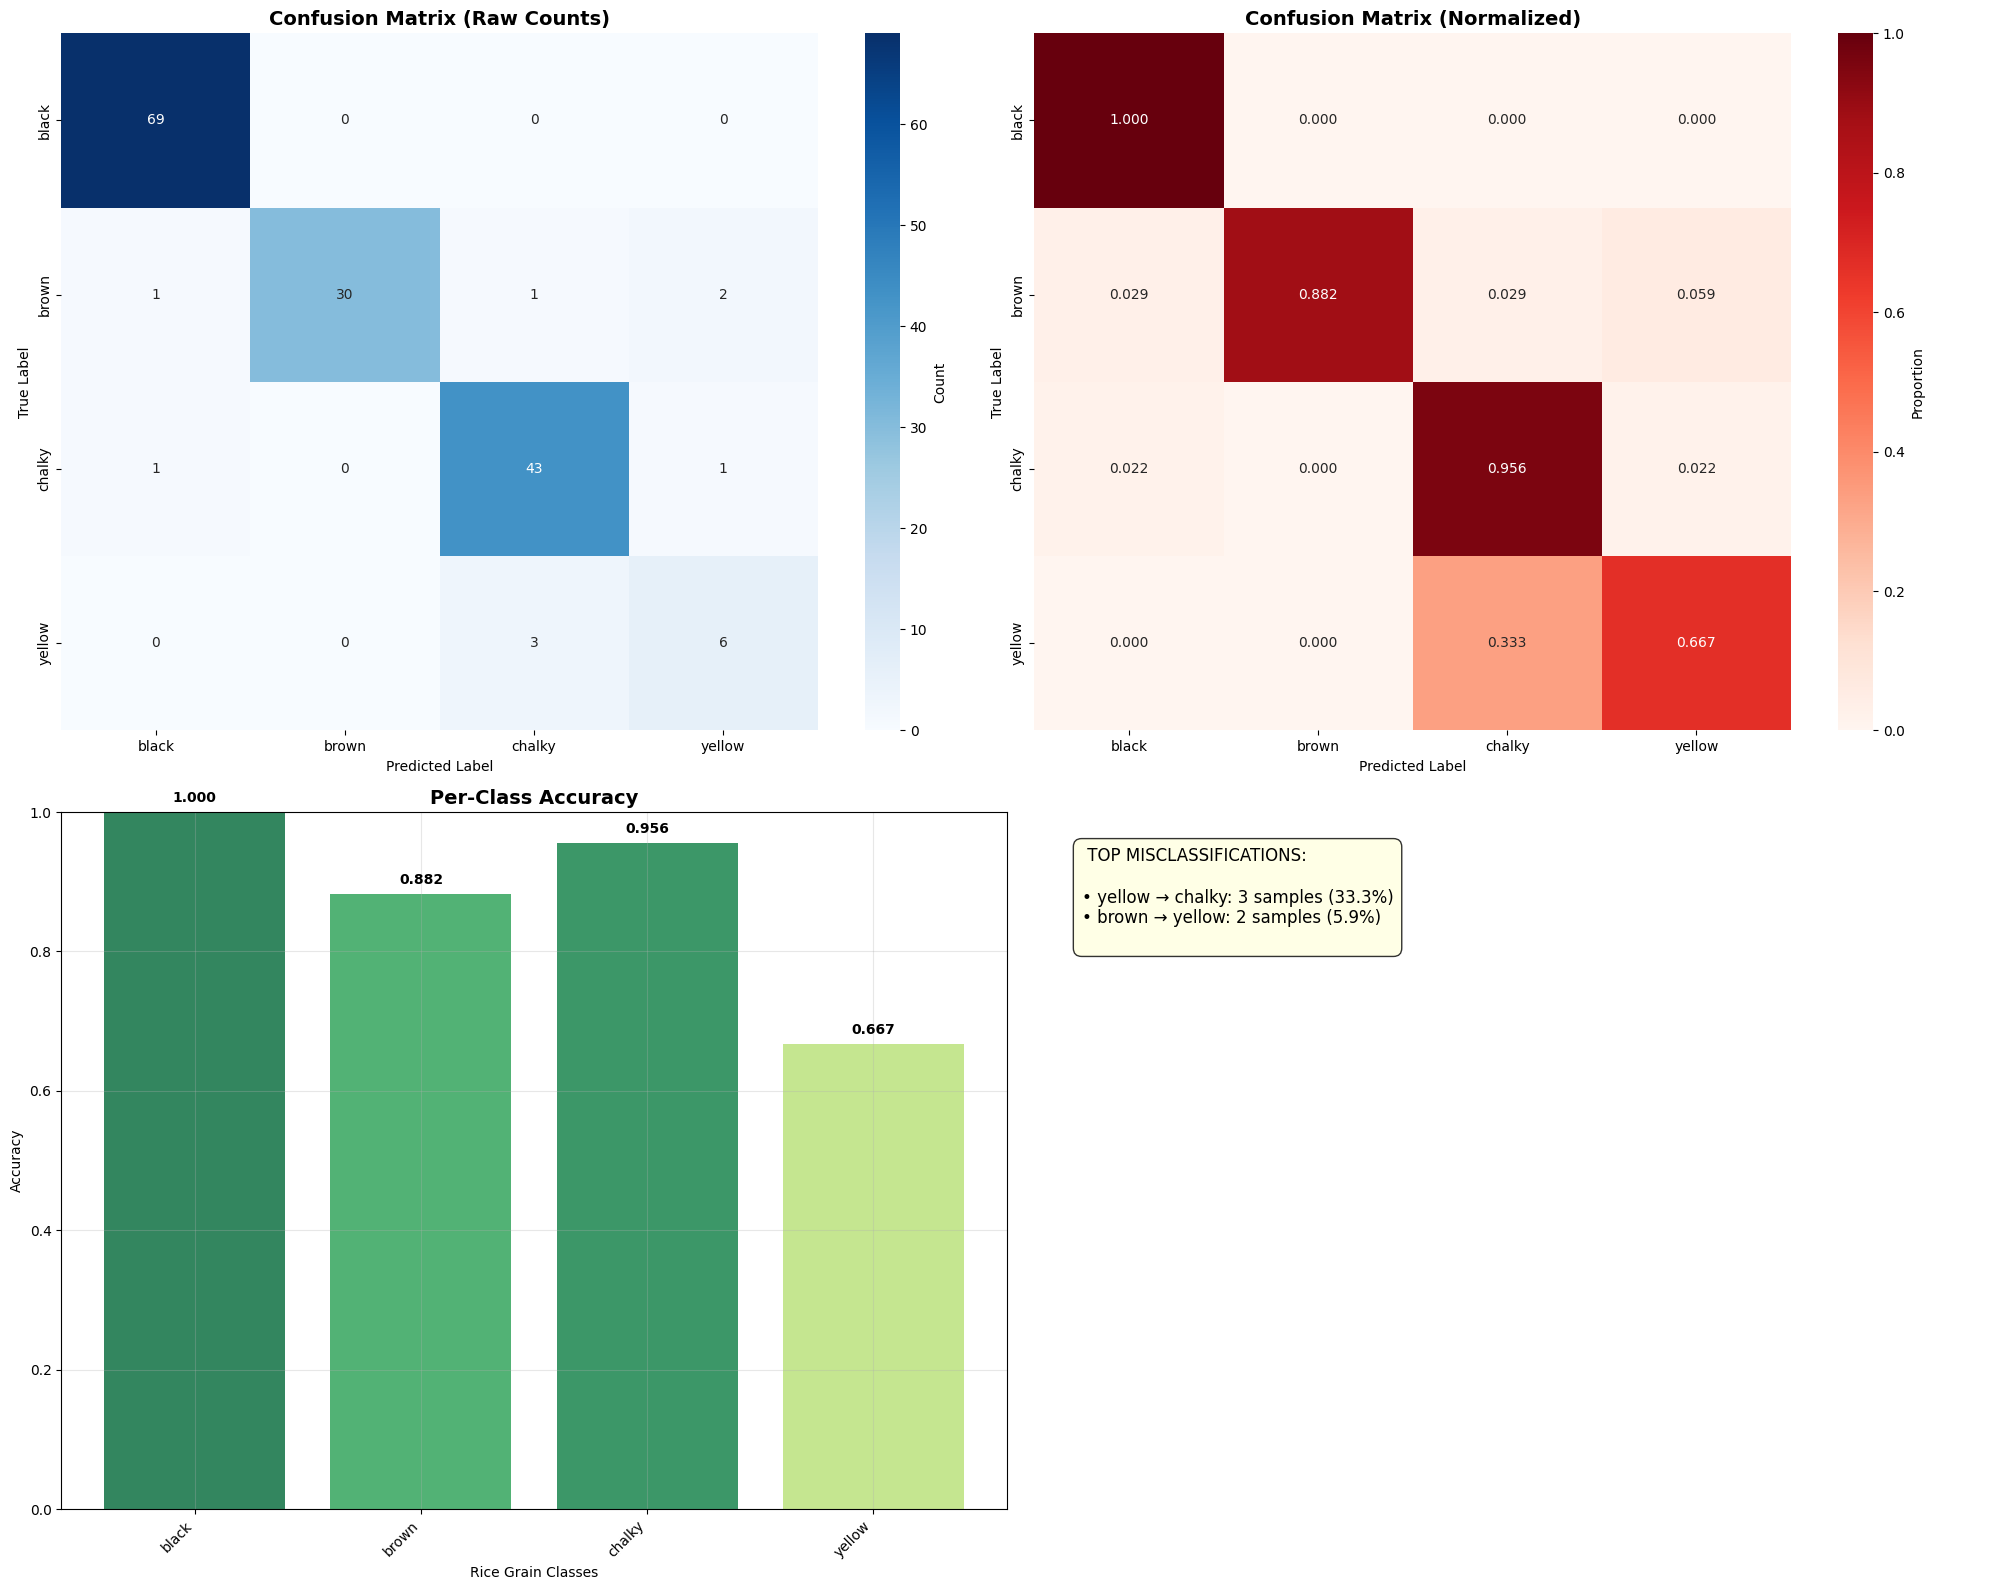


 CONFUSION MATRIX STATISTICS:
   Diagonal sum (correct predictions): 148
   Off-diagonal sum (misclassifications): 9
   Total predictions: 157
   Overall accuracy from CM: 0.9427


In [ ]:
def create_detailed_confusion_matrix(y_true, y_pred, class_names):
    """
    Create detailed confusion matrix with multiple visualizations
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0, 0], cbar_kws={'label': 'Count'})
    axes[0, 0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')

    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0, 1], cbar_kws={'label': 'Proportion'})
    axes[0, 1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('True Label')
    axes[0, 1].set_xlabel('Predicted Label')

    class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
    colors = plt.cm.RdYlGn(class_accuracies)

    bars = axes[1, 0].bar(range(len(class_names)), class_accuracies, color=colors, alpha=0.8)
    axes[1, 0].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Rice Grain Classes')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_xticks(range(len(class_names)))
    axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3)

    for i, (bar, acc) in enumerate(zip(bars, class_accuracies)):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    axes[1, 1].axis('off')

    misclass_data = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                misclass_rate = cm[i, j] / np.sum(cm[i]) * 100
                misclass_data.append({
                    'true': class_names[i],
                    'pred': class_names[j],
                    'count': cm[i, j],
                    'rate': misclass_rate
                })

    misclass_data.sort(key=lambda x: x['rate'], reverse=True)

    misclass_text = " TOP MISCLASSIFICATIONS:\n\n"
    for item in misclass_data[:8]:
        if item['rate'] >= 5:
            misclass_text += f"• {item['true']} → {item['pred']}: {item['count']} samples ({item['rate']:.1f}%)\n"

    if not any(item['rate'] >= 5 for item in misclass_data):
        misclass_text += " No significant misclassifications detected!\n"
        misclass_text += "All confusion rates are below 5%."

    axes[1, 1].text(0.05, 0.95, misclass_text, transform=axes[1, 1].transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return cm, cm_normalized

print(" CONFUSION MATRIX ANALYSIS")
print("=" * 50)

cm_raw, cm_norm = create_detailed_confusion_matrix(y_true, y_pred, CLASS_NAMES)

print(f"\n CONFUSION MATRIX STATISTICS:")
print(f"   Diagonal sum (correct predictions): {np.trace(cm_raw):,}")
print(f"   Off-diagonal sum (misclassifications): {np.sum(cm_raw) - np.trace(cm_raw):,}")
print(f"   Total predictions: {np.sum(cm_raw):,}")
print(f"   Overall accuracy from CM: {np.trace(cm_raw) / np.sum(cm_raw):.4f}")


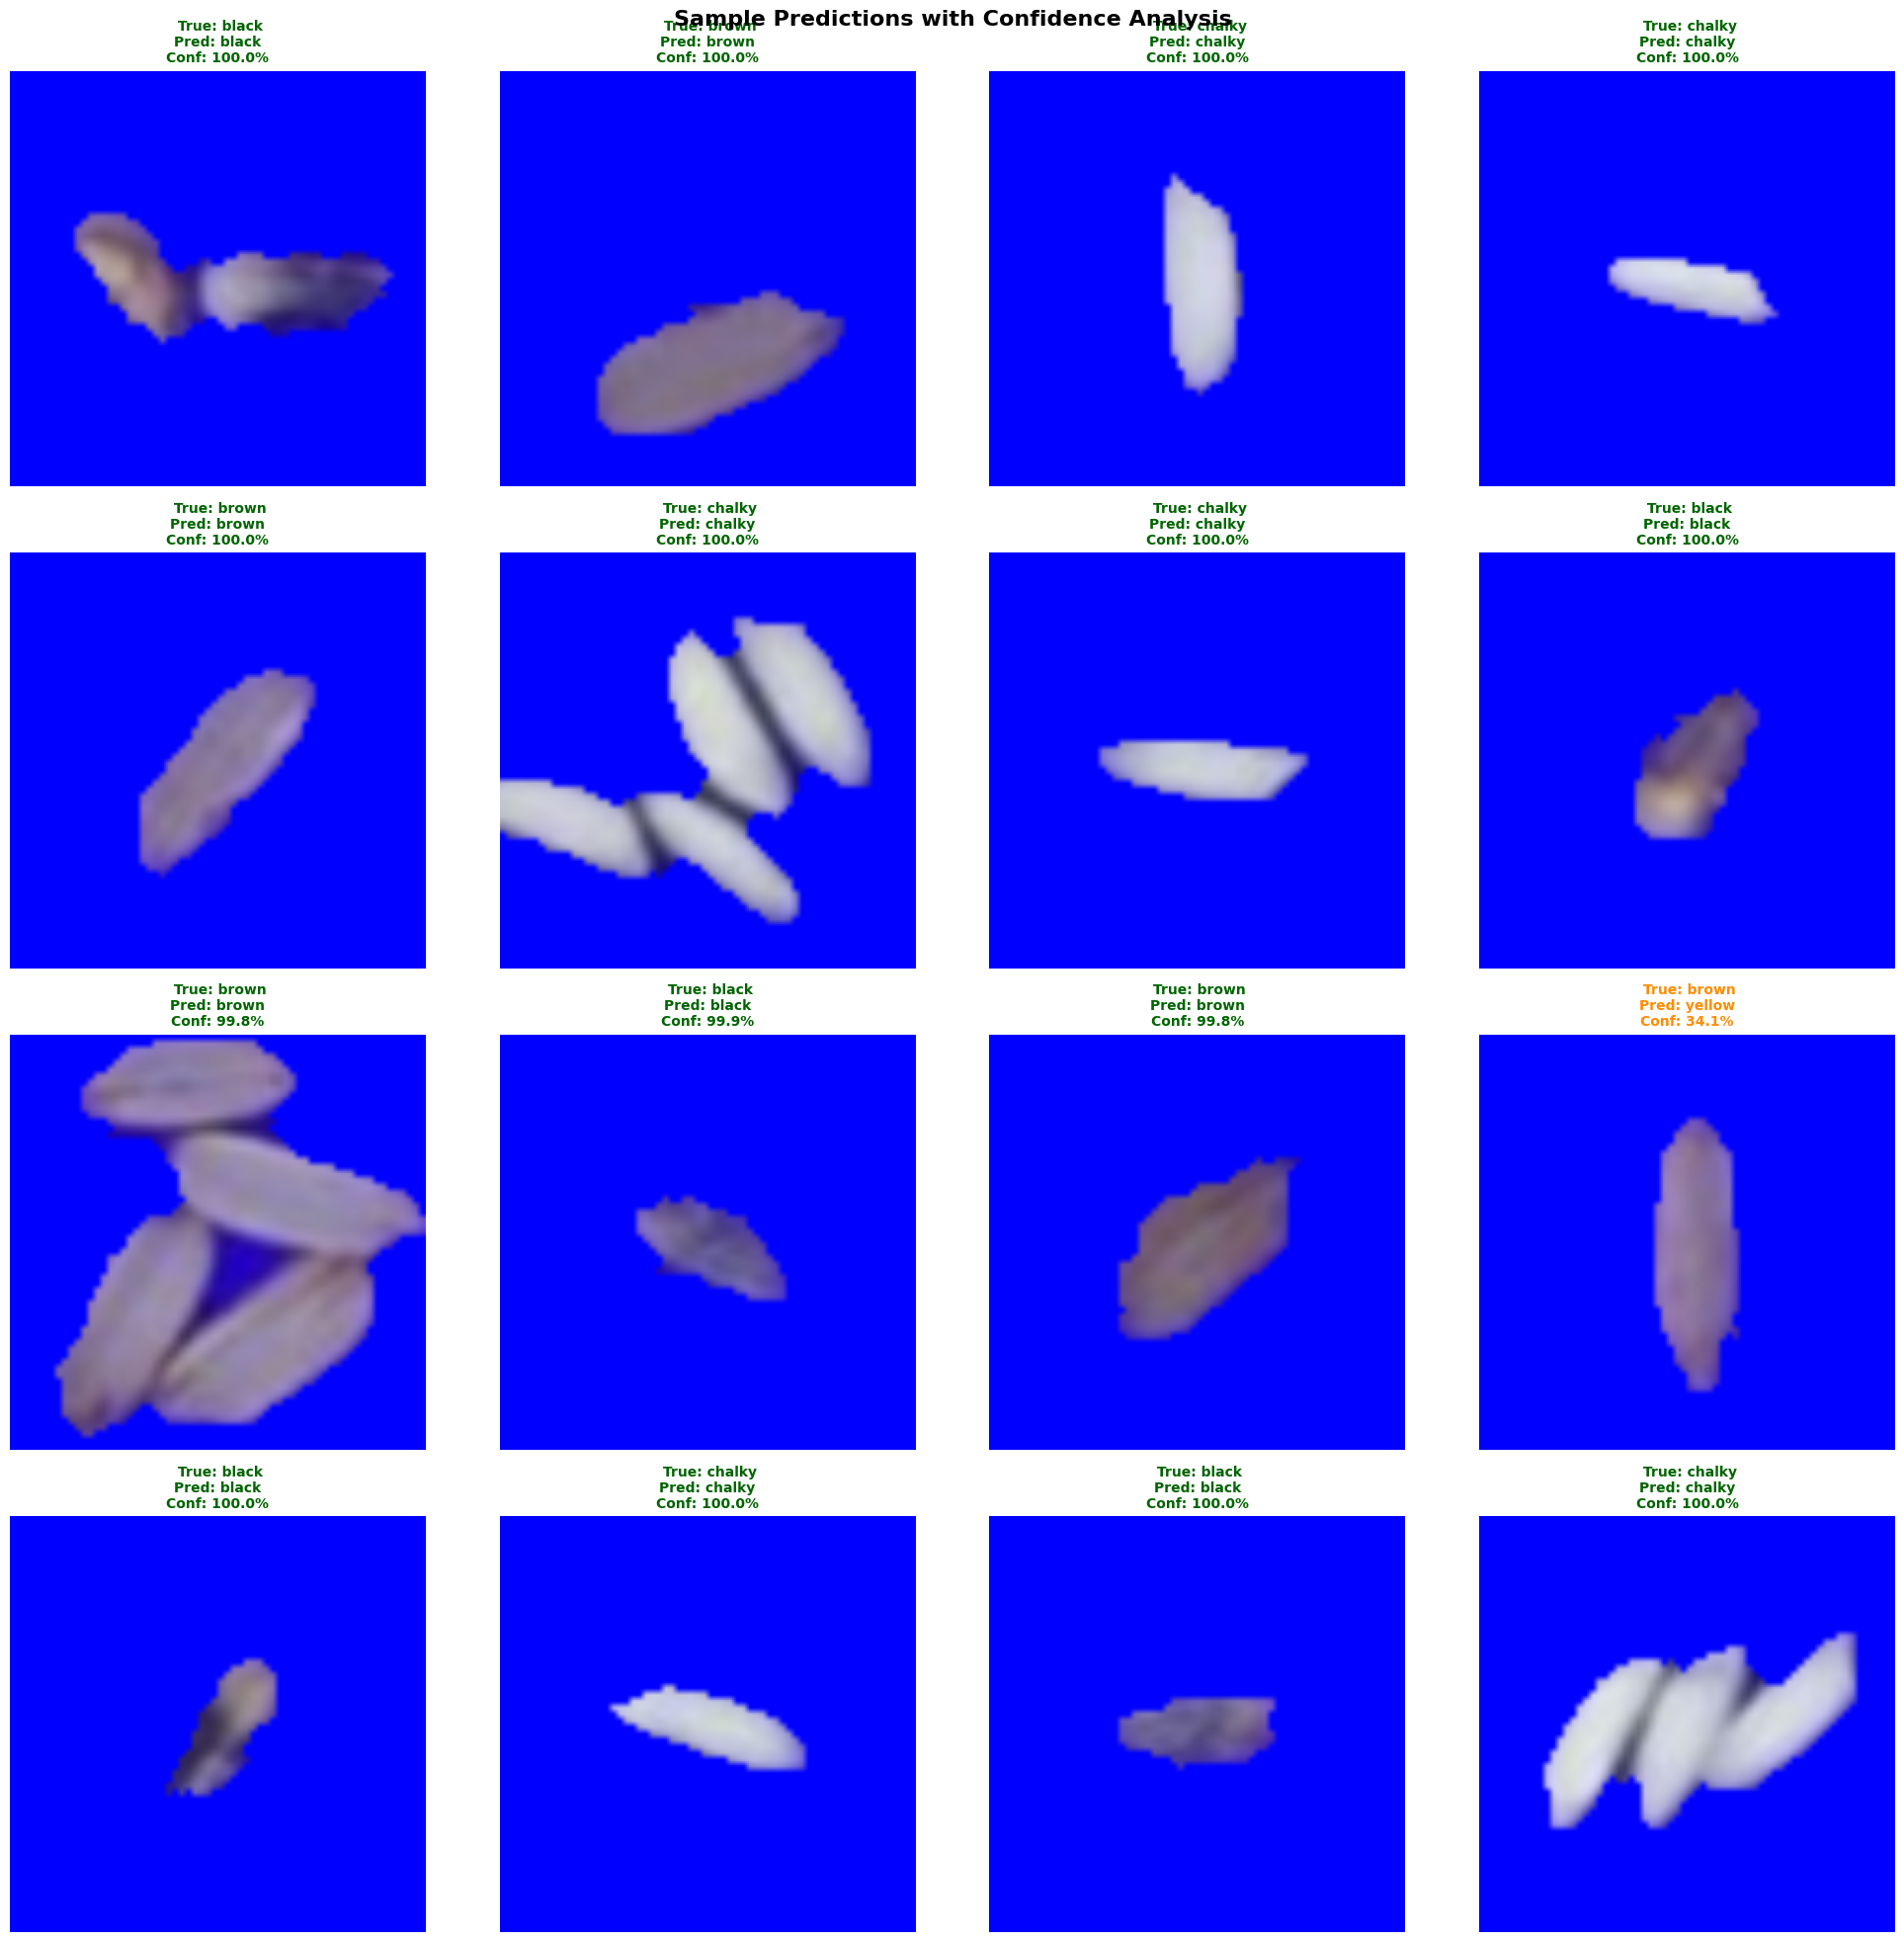


 SAMPLE PREDICTION ANALYSIS:
   Total samples analyzed: 16
   Correct predictions: 15/16 (93.8%)
   High-confidence correct: 15/15 (100.0%)
   Low-confidence incorrect: 1/1 (100.0%)

 CONFIDENCE DISTRIBUTION ANALYSIS:
   Average confidence (all): 97.4%
   Average confidence (correct): 98.8%
   Average confidence (incorrect): 74.4%

 CONFIDENCE BREAKDOWN:
   High confidence (≥90%): 147 samples (93.6%)
   Medium confidence (70-89%): 4 samples (2.5%)
   Low confidence (<70%): 6 samples (3.8%)
 Excellent confidence distribution!


In [ ]:
def visualize_sample_predictions(dataset, model, class_names, num_samples=16):
    """
    Visualize sample predictions with confidence scores and analysis
    """
    print(" Collecting samples for prediction visualization...")

    sample_images = []
    sample_labels = []
    sample_predictions = []

    samples_collected = 0
    for batch_images, batch_labels in dataset:
        if samples_collected >= num_samples:
            break

        batch_size = len(batch_images)
        needed = min(batch_size, num_samples - samples_collected)

        batch_preds = model.predict(batch_images[:needed], verbose=0)

        for i in range(needed):
            sample_images.append(batch_images[i].numpy().astype('uint8'))
            sample_labels.append(np.argmax(batch_labels[i]))
            sample_predictions.append(batch_preds[i])
            samples_collected += 1

    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    axes = axes.ravel()

    correct_predictions = 0
    high_confidence_correct = 0
    low_confidence_incorrect = 0

    for i in range(len(sample_images)):
        ax = axes[i]

        ax.imshow(sample_images[i])

        true_label_idx = sample_labels[i]
        pred_label_idx = np.argmax(sample_predictions[i])
        confidence = np.max(sample_predictions[i]) * 100

        true_label = class_names[true_label_idx]
        pred_label = class_names[pred_label_idx]

        is_correct = (true_label_idx == pred_label_idx)
        is_high_confidence = confidence >= 80

        if is_correct:
            correct_predictions += 1
            if is_high_confidence:
                high_confidence_correct += 1
        else:
            if not is_high_confidence:
                low_confidence_incorrect += 1

        if is_correct and is_high_confidence:
            color = 'darkgreen'
        elif is_correct and not is_high_confidence:
            color = 'orange'
        elif not is_correct and not is_high_confidence:
            color = 'darkorange'
        else:
            color = 'red'

        title = f' True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
        ax.set_title(title, color=color, fontsize=10, fontweight='bold')
        ax.axis('off')

    for i in range(len(sample_images), len(axes)):
        axes[i].axis('off')

    plt.suptitle('Sample Predictions with Confidence Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    total_samples = len(sample_images)
    print(f"\n SAMPLE PREDICTION ANALYSIS:")
    print(f"   Total samples analyzed: {total_samples}")
    print(f"   Correct predictions: {correct_predictions}/{total_samples} ({correct_predictions/total_samples*100:.1f}%)")
    print(f"   High-confidence correct: {high_confidence_correct}/{correct_predictions} ({high_confidence_correct/correct_predictions*100 if correct_predictions > 0 else 0:.1f}%)")
    print(f"   Low-confidence incorrect: {low_confidence_incorrect}/{total_samples - correct_predictions} ({low_confidence_incorrect/(total_samples - correct_predictions)*100 if total_samples - correct_predictions > 0 else 0:.1f}%)")

    return sample_images, sample_labels, sample_predictions

sample_imgs, sample_lbls, sample_preds = visualize_sample_predictions(
    test_ds_processed, model, CLASS_NAMES, num_samples=16
)

all_confidences = np.max(y_pred_proba, axis=1) * 100
correct_mask = (y_true == y_pred)

print(f"\n CONFIDENCE DISTRIBUTION ANALYSIS:")
print(f"   Average confidence (all): {np.mean(all_confidences):.1f}%")
print(f"   Average confidence (correct): {np.mean(all_confidences[correct_mask]):.1f}%")
print(f"   Average confidence (incorrect): {np.mean(all_confidences[~correct_mask]):.1f}%")

high_conf_threshold = 90
medium_conf_threshold = 70

high_conf_mask = all_confidences >= high_conf_threshold
medium_conf_mask = (all_confidences >= medium_conf_threshold) & (all_confidences < high_conf_threshold)
low_conf_mask = all_confidences < medium_conf_threshold

print(f"\n CONFIDENCE BREAKDOWN:")
print(f"   High confidence (≥{high_conf_threshold}%): {np.sum(high_conf_mask):,} samples ({np.sum(high_conf_mask)/len(y_true)*100:.1f}%)")
print(f"   Medium confidence ({medium_conf_threshold}-{high_conf_threshold-1}%): {np.sum(medium_conf_mask):,} samples ({np.sum(medium_conf_mask)/len(y_true)*100:.1f}%)")
print(f"   Low confidence (<{medium_conf_threshold}%): {np.sum(low_conf_mask):,} samples ({np.sum(low_conf_mask)/len(y_true)*100:.1f}%)")

if np.sum(high_conf_mask) / len(y_true) > 0.8:
    print(" Excellent confidence distribution!")
elif np.sum(high_conf_mask) / len(y_true) > 0.6:
    print(" Good confidence distribution!")
else:
    print("  Consider additional training to improve confidence.")


In [ ]:
print(" SAVING FINAL MODEL AND RESULTS")
print("=" * 50)

MODEL_SAVE_PATH = '/content/drive/MyDrive/less_classes.keras'
CONFIG_SAVE_PATH = '/content/drive/MyDrive/less_classes.txt'
RESULTS_SAVE_PATH = '/content/drive/MyDrive/less_classes.csv'
SUMMARY_SAVE_PATH = '/content/drive/MyDrive/less_classes.txt'

print("\ Saving trained model...")
try:
    model.save(MODEL_SAVE_PATH)
    print(f" Model saved successfully: {MODEL_SAVE_PATH}")
except Exception as e:
    print(f" Error saving model: {str(e)}")

print(" Creating configuration file...")
config_info = {
    'model_name': 'Rice Grain EfficientNet-B0 Classifier',
    'created_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'tensorflow_version': tf.__version__,
    'model_architecture': 'EfficientNet-B0 + Custom Classification Head',
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'class_mapping': LABEL_MAP,
    'image_input_size': IMAGE_SIZE,
    'batch_size': BATCH_SIZE,
    'total_epochs_trained': len(history_phase1.history['loss']) + len(history_phase2.history['loss']),
    'phase1_epochs': len(history_phase1.history['loss']),
    'phase2_epochs': len(history_phase2.history['loss']),
    'learning_rate_initial': LEARNING_RATE_INITIAL,
    'learning_rate_finetune': LEARNING_RATE_FINETUNE,
    'total_parameters': model.count_params(),
    'trainable_parameters': sum([tf.size(v).numpy() for v in model.trainable_variables]),
    'final_test_accuracy': test_results['accuracy'],
    'final_test_loss': test_results['loss'],
    'training_samples': total_samples,
    'class_distribution': dict(zip(CLASS_NAMES, class_counts.astype(int).tolist()))
}

try:
    with open(CONFIG_SAVE_PATH, 'w', encoding='utf-8') as f:
        f.write("RICE GRAIN CLASSIFICATION MODEL - CONFIGURATION\n")
        f.write("=" * 60 + "\n\n")

        for key, value in config_info.items():
            f.write(f"{key.replace('_', ' ').title()}: {value}\n")

        f.write(f"\nMODEL USAGE INSTRUCTIONS:\n")
        f.write("-" * 30 + "\n")
        f.write("1. Load model: tf.keras.models.load_model(model_path)\n")
        f.write("2. Preprocess image: Resize to (224, 224), keep [0-255] range\n")
        f.write("3. Predict: model.predict(preprocessed_image)\n")
        f.write("4. Get class: np.argmax(prediction) -> use class_mapping\n")

    print(f" Configuration saved: {CONFIG_SAVE_PATH}")
except Exception as e:
    print(f" Error saving configuration: {str(e)}")

print(" Saving detailed results...")
try:
    detailed_results = []

    for i, class_name in enumerate(CLASS_NAMES):
        class_data = {
            'class_id': i,
            'class_name': class_name,
            'precision': report[class_name]['precision'],
            'recall': report[class_name]['recall'],
            'f1_score': report[class_name]['f1-score'],
            'support': int(report[class_name]['support']),
            'training_samples': int(class_counts[i]),
            'class_weight': class_weight_dict[i]
        }
        detailed_results.append(class_data)

    summary_data = {
        'class_id': -1,
        'class_name': 'OVERALL',
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score'],
        'support': int(report['weighted avg']['support']),
        'training_samples': int(np.sum(class_counts)),
        'class_weight': 1.0
    }
    detailed_results.append(summary_data)

    results_df = pd.DataFrame(detailed_results)
    results_df.to_csv(RESULTS_SAVE_PATH, index=False)
    print(f" Detailed results saved: {RESULTS_SAVE_PATH}")

except Exception as e:
    print(f" Error saving results: {str(e)}")

print(" Creating model summary...")
try:
    with open(SUMMARY_SAVE_PATH, 'w', encoding='utf-8') as f:
        f.write("RICE GRAIN CLASSIFICATION - MODEL SUMMARY\n")
        f.write("=" * 50 + "\n\n")

        f.write(" FINAL PERFORMANCE:\n")
        f.write(f"   Test Accuracy: {test_results['accuracy']:.4f}\n")
        f.write(f"   Test Loss: {test_results['loss']:.4f}\n")
        f.write(f"   Test Precision: {test_results['precision']:.4f}\n")
        f.write(f"   Test Recall: {test_results['recall']:.4f}\n")
        f.write(f"   Test AUC: {test_results['auc']:.4f}\n\n")

        f.write(" DATASET INFORMATION:\n")
        f.write(f"   Total Classes: {NUM_CLASSES}\n")
        f.write(f"   Training Samples: {total_samples:,}\n")
        f.write(f"   Test Samples: {len(y_true):,}\n\n")

        f.write(" MODEL ARCHITECTURE:\n")
        f.write(f"   Base Model: EfficientNet-B0 (ImageNet pretrained)\n")
        f.write(f"   Total Parameters: {model.count_params():,}\n")
        f.write(f"   Input Shape: {IMAGE_SIZE}\n")
        f.write(f"   Training Strategy: Two-phase transfer learning\n\n")

        f.write(" CLASS PERFORMANCE:\n")
        for i, class_name in enumerate(CLASS_NAMES):
            f.write(f"   {class_name}: F1={report[class_name]['f1-score']:.4f}, "
                   f"Precision={report[class_name]['precision']:.4f}, "
                   f"Recall={report[class_name]['recall']:.4f}\n")

    print(f" Model summary saved: {SUMMARY_SAVE_PATH}")

except Exception as e:
    print(f" Error saving summary: {str(e)}")

print(f"\n MODEL TRAINING AND EVALUATION COMPLETE!")
print("=" * 60)
print(f" Saved Files:")
print(f"   • Model: {MODEL_SAVE_PATH}")
print(f"   • Configuration: {CONFIG_SAVE_PATH}")
print(f"   • Results: {RESULTS_SAVE_PATH}")
print(f"   • Summary: {SUMMARY_SAVE_PATH}")
print(f"\n Final Performance: {test_results['accuracy']:.4f} accuracy on test set")
print(f" Model ready for rice grain classification!")


 SAVING FINAL MODEL AND RESULTS
\ Saving trained model...
 Model saved successfully: /content/drive/MyDrive/less_classes.keras
 Creating configuration file...
 Configuration saved: /content/drive/MyDrive/less_classes.txt
 Saving detailed results...
 Detailed results saved: /content/drive/MyDrive/less_classes.csv
 Creating model summary...
 Model summary saved: /content/drive/MyDrive/less_classes.txt

 MODEL TRAINING AND EVALUATION COMPLETE!
 Saved Files:
   • Model: /content/drive/MyDrive/less_classes.keras
   • Configuration: /content/drive/MyDrive/less_classes.txt
   • Results: /content/drive/MyDrive/less_classes.csv
   • Summary: /content/drive/MyDrive/less_classes.txt

 Final Performance: 0.9427 accuracy on test set
 Model ready for rice grain classification!
